## Beijing Multisite Air Quality Dataset (Seasonal)

This dataset includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017. Missing data are denoted as NA.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from sklearn.metrics import mean_squared_error
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv('Beijing Multisite air Quality data.csv')

In [4]:
df

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
420764,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
420765,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
420766,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


In [5]:
df.isnull().sum()

year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

In [6]:
df = df.dropna()

### Combining the 'year', 'month', 'day', and 'hour' columns are into a datetime column
 

In [7]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

df.set_index('datetime', inplace=True)

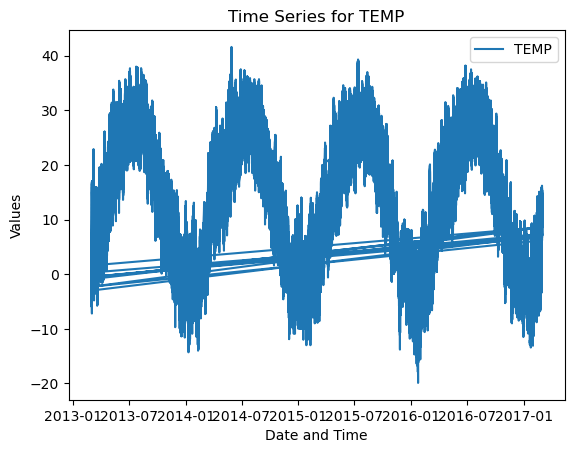

In [8]:
# Plot time series for each specified column individually without setting size
plt.plot(df.index, df['TEMP'], label='TEMP')
plt.title('Time Series for TEMP')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.legend()
plt.show()


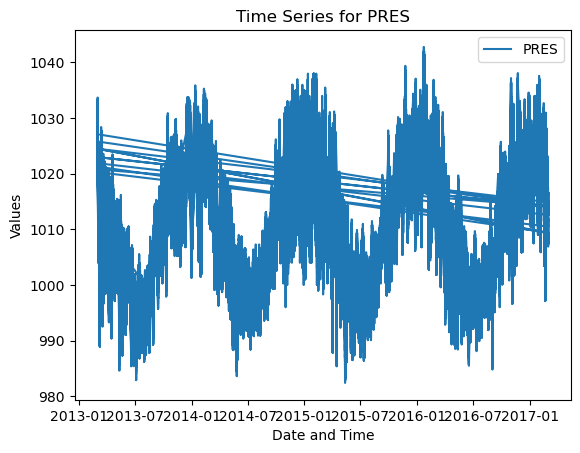

In [9]:
plt.plot(df.index, df['PRES'], label='PRES')
plt.title('Time Series for PRES')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.legend()
plt.show()


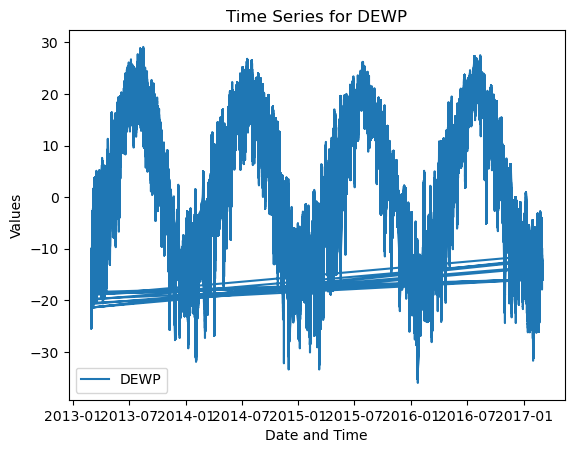

In [10]:
plt.plot(df.index, df['DEWP'], label='DEWP')
plt.title('Time Series for DEWP')
plt.xlabel('Date and Time')
plt.ylabel('Values')
plt.legend()
plt.show()

### Ploting  ACF and PACF for parameter selection


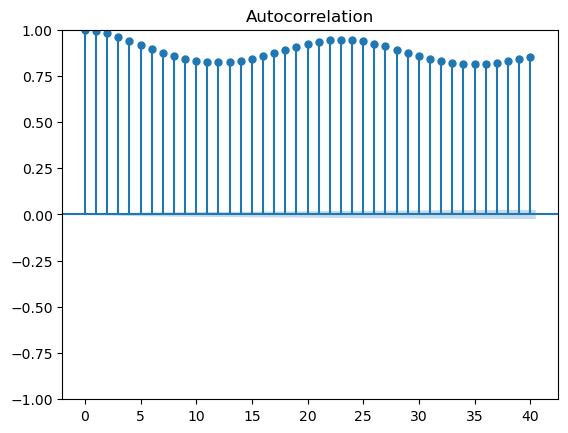

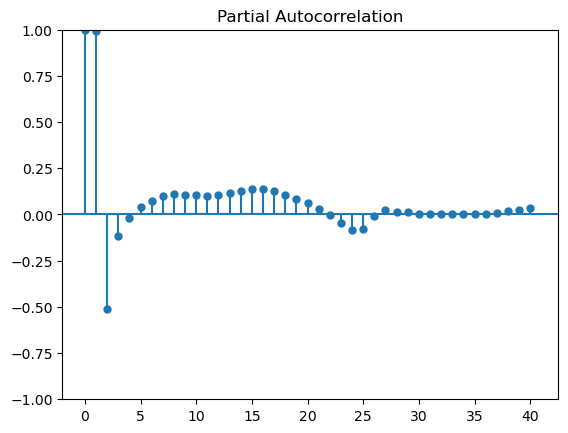

In [11]:
plot_acf(df['TEMP'], lags=40)
plot_pacf(df['TEMP'], lags=40)
plt.show()

### Checking the Stationarity

In [12]:
result = adfuller(df['TEMP'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Check if the data is stationary
if result[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")


ADF Statistic: -8.546733540223938
p-value: 9.458849758968902e-14
Critical Values: {'1%': -3.430367115475446, '5%': -2.8615475648335447, '10%': -2.5667740264854584}
The data is stationary.


In [13]:
np.random.seed(42)

# Generate example data for illustration purposes
date_rng = pd.date_range(start='2013-02-05', end='2017-12-31', freq='M')
data = np.random.randn(len(date_rng))
df = pd.DataFrame(data, columns=['TEMP'], index=date_rng)

# Split your data into training and testing sets
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

### Finding Models and parameter estimation

In [14]:
# SARIMA model
p, d, q = 2, 0, 2  
P, D, Q, s = 1, 0, 0, 12 

# Fit SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(train_data['TEMP'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit(disp=False)

# 5. Parameter Estimation
print("SARIMA Model Parameters:")
print(sarima_results.summary())


SARIMA Model Parameters:
                                      SARIMAX Results                                      
Dep. Variable:                                TEMP   No. Observations:                   47
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 12)   Log Likelihood                 -60.513
Date:                             Fri, 26 Apr 2024   AIC                            133.027
Time:                                     20:12:37   BIC                            144.128
Sample:                                 02-28-2013   HQIC                           137.204
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1674      0.363      0.461      0.645      -0.544       0.879
ar

In [15]:
# SARIMA model
p, d, q = 0, 0,3  
P, D, Q, s = 0, 0, 0, 12 

# Fit SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(train_data['TEMP'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit(disp=False)

# 5. Parameter Estimation
print("SARIMA Model Parameters:")
print(sarima_results.summary())


SARIMA Model Parameters:
                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                   47
Model:               SARIMAX(0, 0, 3)   Log Likelihood                 -61.269
Date:                Fri, 26 Apr 2024   AIC                            130.537
Time:                        20:12:37   BIC                            137.938
Sample:                    02-28-2013   HQIC                           133.322
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1842      0.166      1.110      0.267      -0.141       0.509
ma.L2         -0.1622      0.190     -0.856      0.392      -0.534       0.209
ma.L3          0.4559      

### Residual Analysis

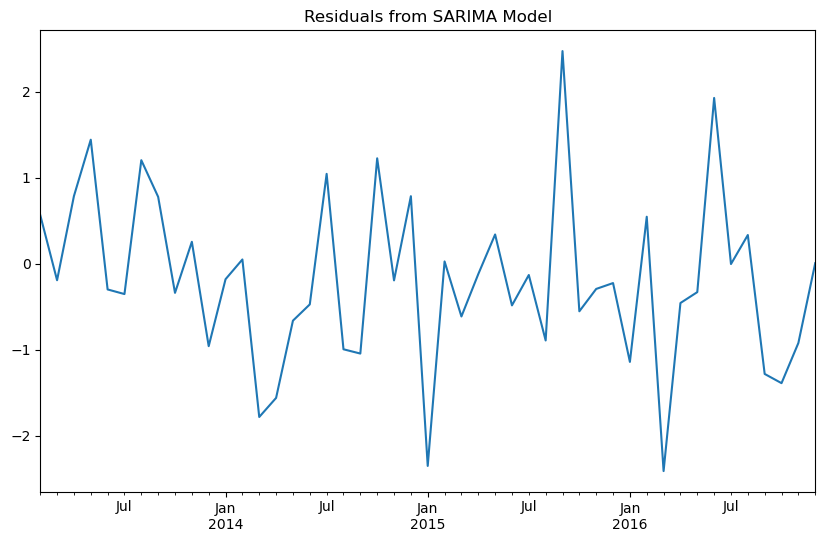

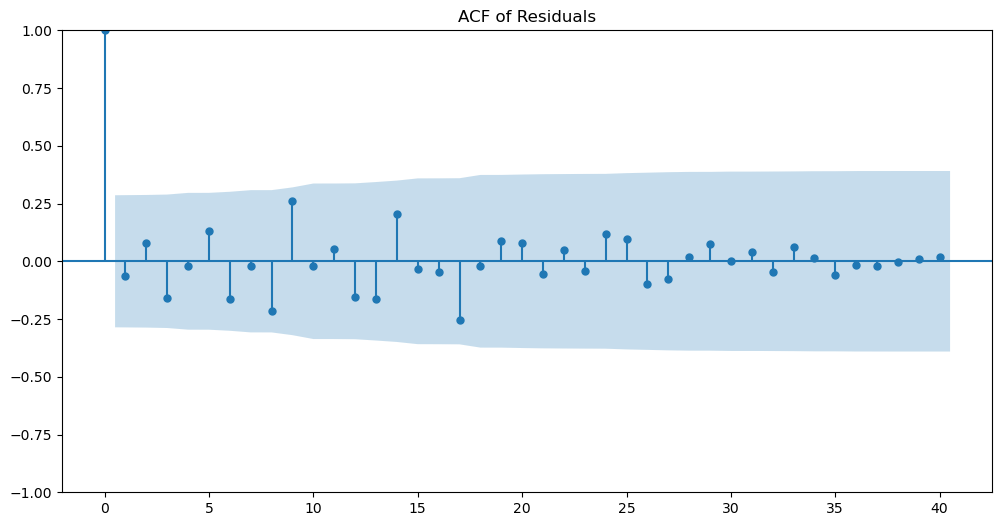

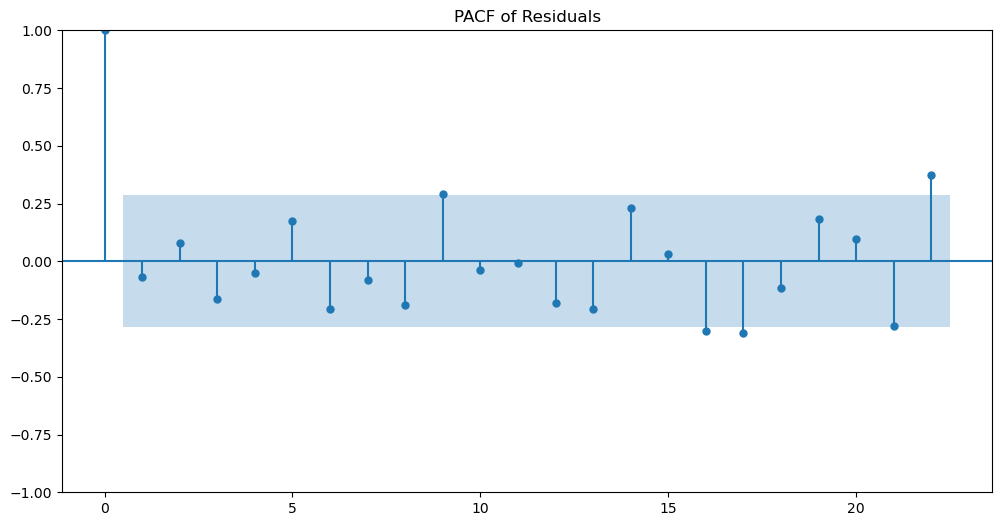

In [16]:
residuals = sarima_results.resid / sarima_results.resid.std()
fig, ax = plt.subplots(figsize=(10, 6))
residuals.plot(ax=ax)
ax.set_title('Residuals from SARIMA Model')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(residuals, lags=min(40, len(residuals)-1), ax=ax, title='ACF of Residuals')
plt.show()

pacf_lags = min(40, len(residuals)//2 - 1)

fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(residuals, lags=pacf_lags, ax=ax, title='PACF of Residuals')
plt.show()

## Performing  Ljung-Box Test on Residuals


In [17]:
lb_test_result = sm.stats.acorr_ljungbox(residuals, lags=10, return_df=True)
print("Ljung-Box Test Results:")
print(lb_test_result)

Ljung-Box Test Results:
      lb_stat  lb_pvalue
1    0.209421   0.647222
2    0.537227   0.764439
3    1.888158   0.595941
4    1.915426   0.751311
5    2.842361   0.724273
6    4.310437   0.634744
7    4.331165   0.740941
8    7.033408   0.533033
9   11.100038   0.268914
10  11.121070   0.348164


### Plotting the p-values

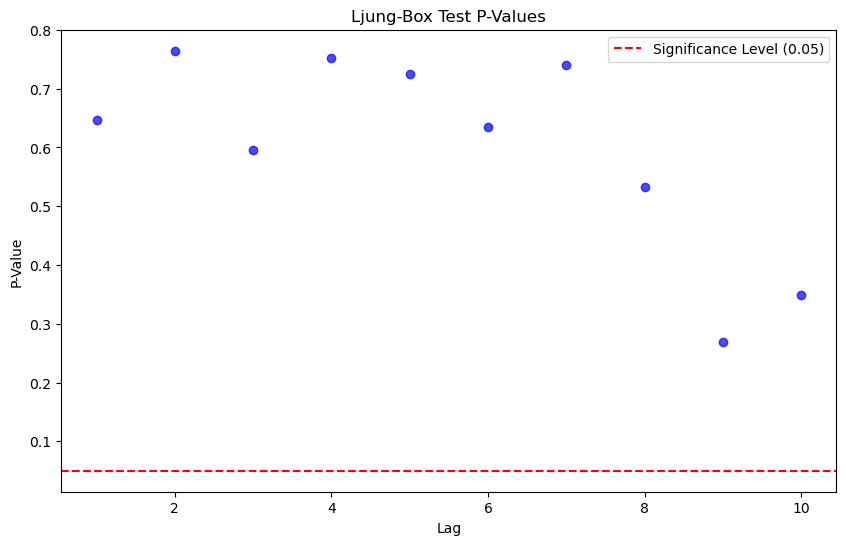

In [18]:
p_values = lb_test_result['lb_pvalue']

# Plotting the p-values
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(p_values) + 1), p_values, color='blue', alpha=0.7)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.title('Ljung-Box Test P-Values')
plt.xlabel('Lag')
plt.ylabel('P-Value')
plt.legend()
plt.show()


### SARIMA Models with Seasonal Component and Forecasting 

In [21]:
p, d, q = 2, 0, 2  # Non-seasonal orders
P, D, Q, s = 1, 0, 0, 12  # Seasonal orders with a seasonal period of 12 (for monthly data)
sarima_model = sm.tsa.SARIMAX(train_data['TEMP'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()

sarima_predictions = sarima_results.get_forecast(steps=len(test_data))
sarima_predicted_values = sarima_predictions.predicted_mean
sarima_conf_int = sarima_predictions.conf_int()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34900D+00    |proj g|=  1.05012D-01

At iterate    5    f=  1.33968D+00    |proj g|=  2.61060D-02

At iterate   10    f=  1.32758D+00    |proj g|=  3.31709D-02

At iterate   15    f=  1.29725D+00    |proj g|=  4.09330D-02

At iterate   20    f=  1.29132D+00    |proj g|=  6.45595D-03

At iterate   25    f=  1.29126D+00    |proj g|=  2.34100D-03

At iterate   30    f=  1.29101D+00    |proj g|=  2.08149D-03

At iterate   35    f=  1.29086D+00    |proj g|=  2.42623D-03

At iterate   40    f=  1.28945D+00    |proj g|=  3.31516D-02

At iterate   45    f=  1.28800D+00    |proj g|=  1.68260D-02

At iterate   50    f=  1.28752D+00    |proj g|=  7.26696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

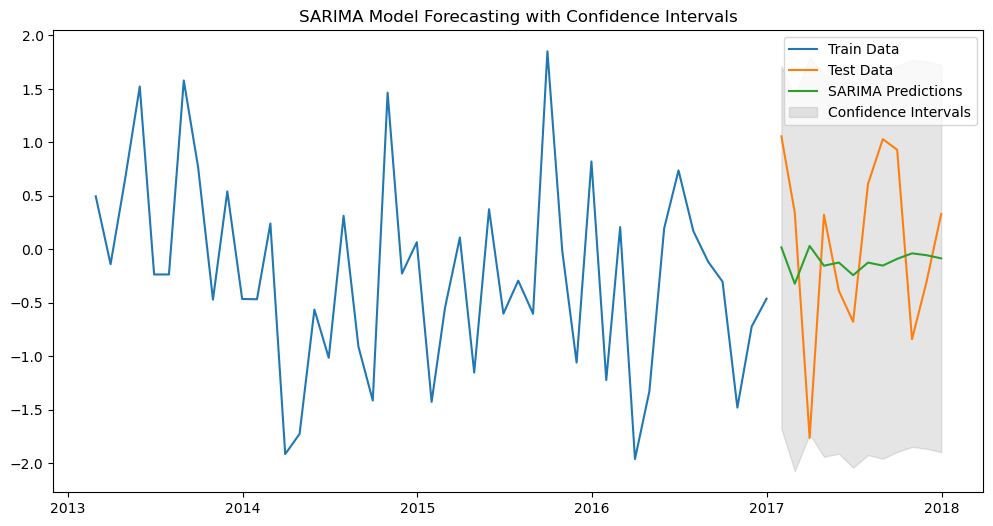

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['TEMP'], label='Train Data')
plt.plot(test_data.index, test_data['TEMP'], label='Test Data')
plt.plot(sarima_predicted_values.index, sarima_predicted_values, label='SARIMA Predictions')
plt.fill_between(sarima_conf_int.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='gray', alpha=0.2, label='Confidence Intervals')
plt.title('SARIMA Model Forecasting with Confidence Intervals')
plt.legend()
plt.show()

In [23]:
# SARIMA Model with Seasonal Component
p, d, q = 0, 0, 3  # Non-seasonal orders
P, D, Q, s = 0, 0, 0, 12  # Seasonal orders with a seasonal period of 12 (for monthly data)
sarima_model = sm.tsa.SARIMAX(train_data['TEMP'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()

# Make predictions on the test set with confidence intervals
sarima_predictions = sarima_results.get_forecast(steps=len(test_data))
sarima_predicted_values = sarima_predictions.predicted_mean
sarima_conf_int = sarima_predictions.conf_int()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33043D+00    |proj g|=  1.14940D-01

At iterate    5    f=  1.30475D+00    |proj g|=  4.04171D-02

At iterate   10    f=  1.30359D+00    |proj g|=  8.37596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   1.672D-06   1.304D+00
  F =   1.3035895002753002     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


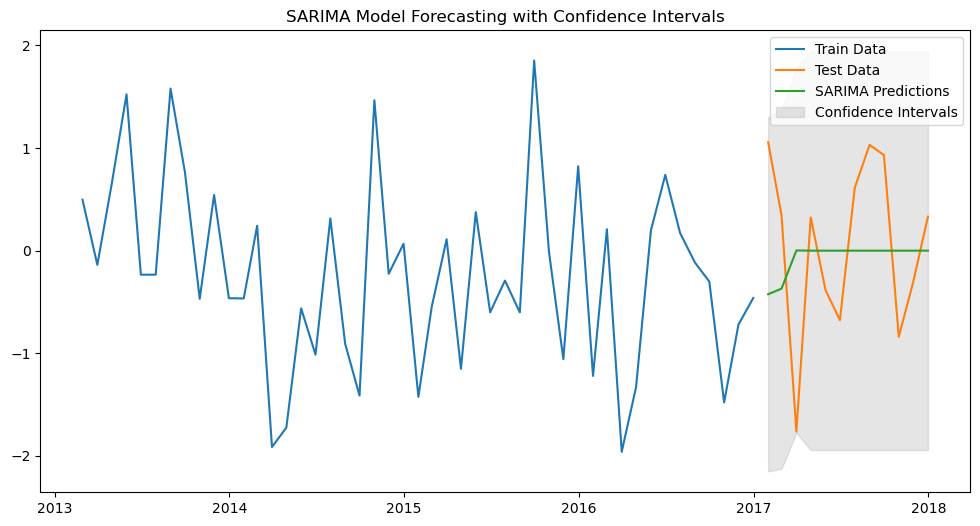

In [24]:
# Plot SARIMA predictions with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['TEMP'], label='Train Data')
plt.plot(test_data.index, test_data['TEMP'], label='Test Data')
plt.plot(sarima_predicted_values.index, sarima_predicted_values, label='SARIMA Predictions')
plt.fill_between(sarima_conf_int.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='gray', alpha=0.2, label='Confidence Intervals')
plt.title('SARIMA Model Forecasting with Confidence Intervals')
plt.legend()
plt.show()
